In [1]:
%matplotlib inline
import sys
BIN = ''
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms
import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

from fastai import data_block, basic_train, basic_data
import fastai

In [2]:
from nn_utils import AE_basic, AE_bn, AE_LeakyReLU, AE_bn_LeakyReLU

In [3]:
# Load data
#train = pd.read_pickle(BIN + 'processed_data/aod/partial_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/partial_test.pkl')

#train = pd.read_pickle(BIN + 'processed_data/aod/full_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/full_test.pkl')

train = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_train_10percent.pkl')
test = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_test_10percent.pkl')

#train = pd.read_pickle(BIN + 'processed_data/aod/all_jets_full_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/all_jets_full_test.pkl')

#train['pt'] = train['pt'] / 1000.  # Convert to GeV
#test['pt'] = test['pt'] / 1000.  # Convert to GeV
#train['m'] = train['m'] / 1000.  # Convert to GeV
#test['m'] = test['m'] / 1000.  # Convert to GeV
#train['NegativeE'] = train['NegativeE'] / 1000.  # Convert to GeV
#test['NegativeE'] = test['NegativeE'] / 1000.  # Convert to GeV

#train['LeadingClusterPt'] = train['LeadingClusterPt'] / 1000.  # Convert to GeV
#test['LeadingClusterPt'] = test['LeadingClusterPt'] / 1000.  # Convert to GeV

#train['LeadingClusterSecondR'] = train['LeadingClusterSecondR'] / 1000.  # Convert to GeV
#test['LeadingClusterSecondR'] = test['LeadingClusterSecondR'] / 1000.  # Convert to GeV

#train['LeadingClusterSecondLambda'] = train['LeadingClusterSecondLambda'] / 1000.  # Convert to GeV
#test['LeadingClusterSecondLambda'] = test['LeadingClusterSecondLambda'] / 1000.  # Convert to GeV

train.pop('JetGhostArea')
test.pop('JetGhostArea')
train.pop('BchCorrCell')
test.pop('BchCorrCell')

# Remove all jets with EMFrac outside (-2, 2)
train = train[(train['EMFrac'] < 2) & (train['EMFrac'] > -2)]
test = test[(test['EMFrac'] < 2) & (test['EMFrac'] > -2)]

In [4]:
for key in test.keys():
    print(key)

pt
eta
phi
m
ActiveArea
ActiveArea4vec_eta
ActiveArea4vec_m
ActiveArea4vec_phi
ActiveArea4vec_pt
AverageLArQF
NegativeE
HECQuality
LArQuality
Width
WidthPhi
CentroidR
DetectorEta
LeadingClusterCenterLambda
LeadingClusterPt
LeadingClusterSecondLambda
LeadingClusterSecondR
N90Constituents
EMFrac
HECFrac
Timing
OotFracClusters10
OotFracClusters5


In [22]:
len(train.keys())

27

In [7]:
train.head()

,pt,eta,phi,m,ActiveArea,ActiveArea4vec_eta,ActiveArea4vec_m,ActiveArea4vec_phi,ActiveArea4vec_pt,AverageLArQF,...,LeadingClusterCenterLambda,LeadingClusterPt,LeadingClusterSecondLambda,LeadingClusterSecondR,N90Constituents,EMFrac,HECFrac,Timing,OotFracClusters10,OotFracClusters5
0,99859.093750,-0.342858,2.134567,8093.725586,0.478719,-0.353398,0.132767,2.131208,0.469330,108.751984,...,1264.798706,25836.232422,343890.343750,43809.390625,5.0,0.612864,0.000000,0.864557,0.007613,0.017692
1,45352.539062,-0.454986,-2.667796,6373.729980,0.498666,-0.469833,0.140288,-2.671408,0.489406,837.354065,...,1027.079468,19099.195312,54438.531250,72658.773438,6.0,0.509103,0.000000,11.380662,0.495797,0.590913
2,26483.806641,1.440664,1.628155,5337.418457,0.538559,1.447917,0.156741,1.641177,0.527291,293.155884,...,95.400406,4939.110352,2175.471191,5361.905273,5.0,0.401359,0.000000,1.700485,0.188751,0.188751
3,21745.404297,-0.112350,-2.588387,4982.305664,0.448799,-0.128731,0.126130,-2.650139,0.442389,263.850281,...,84.082619,10380.062500,20607.902344,6131.678223,8.0,0.863900,0.000000,1.283107,0.090132,0.145812
4,87560.859375,-2.752789,-2.295353,16907.716797,0.518612,-2.782047,0.150488,-2.293478,0.508540,3159.353760,...,921.882202,39378.828125,81567.531250,13050.795898,4.0,0.565845,0.434155,-1.213494,0.000000,0.000000


In [8]:
def plot_data(data, e_range=None, pt_range=None, save=False, title=True, logy=False):

    plt.figure()
    plt.hist(data['pt'], bins=100, range=pt_range)
    plt.xlabel(r'$p_T$')
    if title:
        plt.suptitle('Train set')
    plt.ylabel('Number of jets')
    ms.sciy()
    if logy:
        plt.yscale('log')
    if save:
        plt.savefig('data_exploration_figures/hist_pt_train.png')
    
    plt.figure()
    plt.hist(data['eta'], bins=100)
    plt.xlabel(r'$\eta$')
    if title:
        plt.suptitle('Train set')
    plt.ylabel('Number of jets')
    ms.sciy()
    if save:
        plt.savefig('data_exploration_figures/hist_eta_train.png')
    
    plt.figure()
    plt.hist(data['phi'], bins=100)
    plt.xlabel(r'$\phi$')
    if title:
        plt.suptitle('Train set')
    plt.ylabel('Number of jets')
    ms.sciy()
    if save:
        plt.savefig('data_exploration_figures/hist_phi_train.png')    
        
    plt.figure()
    plt.hist(data['m'], bins=100, range=e_range)
    plt.xlabel(r'$m$')
    if title:
        plt.suptitle('Train set')
    plt.ylabel('Number of jets')
    ms.sciy()
    if logy:
        plt.yscale('log')
    if save:
        plt.savefig('data_exploration_figures/hist_m_train.png')

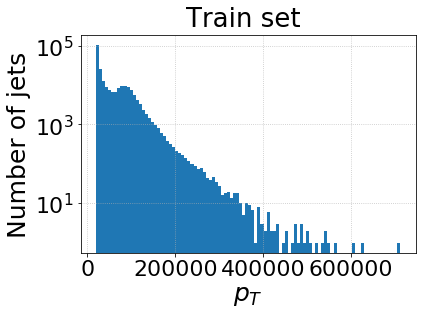

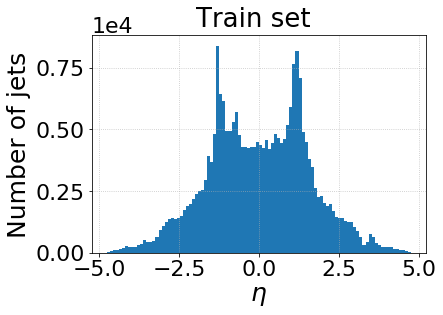

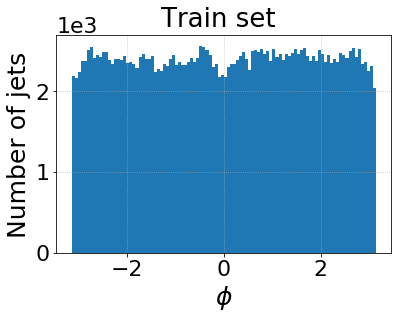

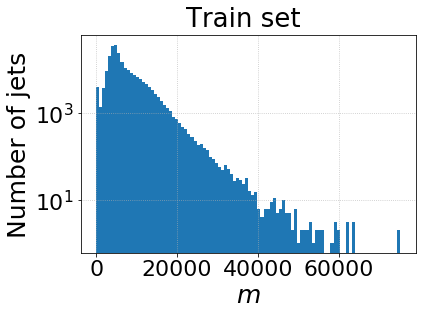

In [9]:
plot_data(test, logy=True)

In [10]:
test.keys()

Index(['pt', 'eta', 'phi', 'm', 'ActiveArea', 'ActiveArea4vec_eta',
       'ActiveArea4vec_m', 'ActiveArea4vec_phi', 'ActiveArea4vec_pt',
       'AverageLArQF', 'NegativeE', 'HECQuality', 'LArQuality', 'Width',
       'WidthPhi', 'CentroidR', 'DetectorEta', 'LeadingClusterCenterLambda',
       'LeadingClusterPt', 'LeadingClusterSecondLambda',
       'LeadingClusterSecondR', 'N90Constituents', 'EMFrac', 'HECFrac',
       'Timing', 'OotFracClusters10', 'OotFracClusters5'],
      dtype='object')

In [11]:
def plot_all(data, logy=False):
    for key in data.keys():
        plt.figure()
        plt.hist(data[key], bins=200)
        plt.xlabel(str(key))
        plt.ylabel('Number of jets')
        if logy:
            plt.yscale('log')
        else:
            ms.sciy()

/home/skelpdar/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


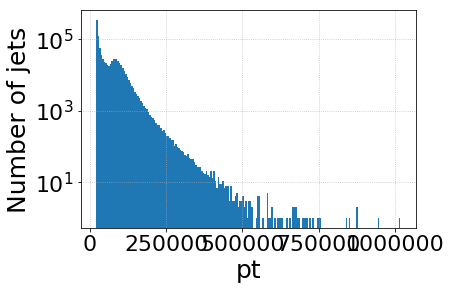

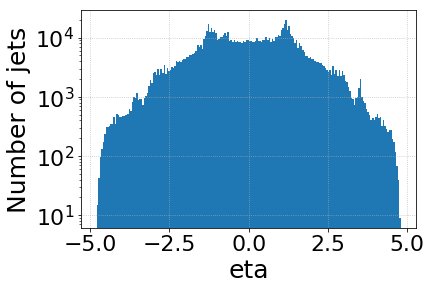

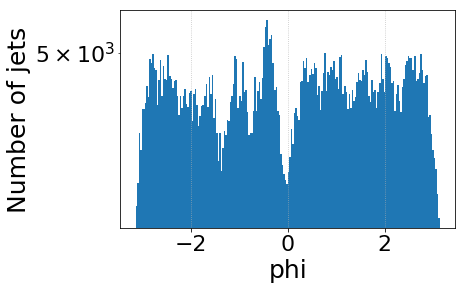

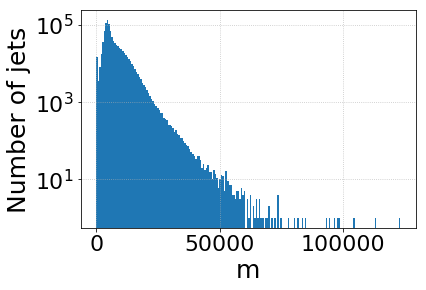

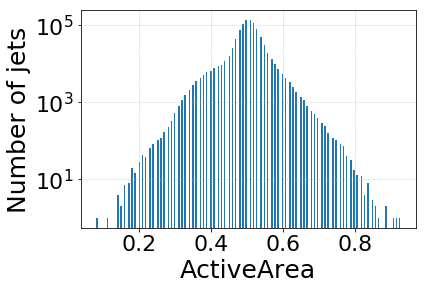

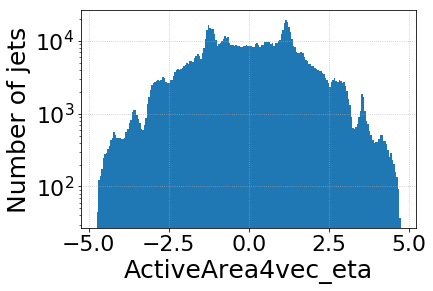

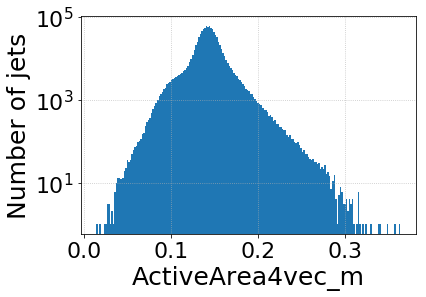

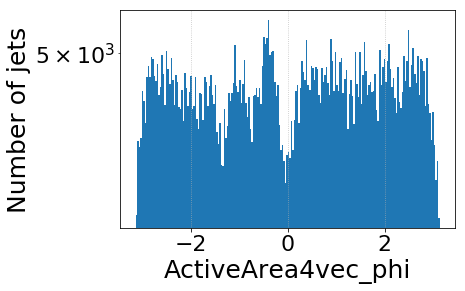

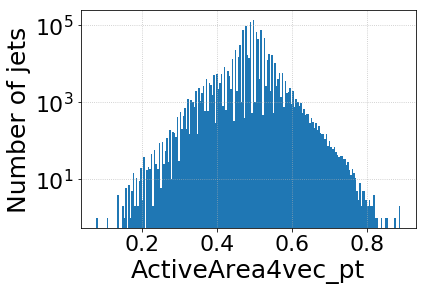

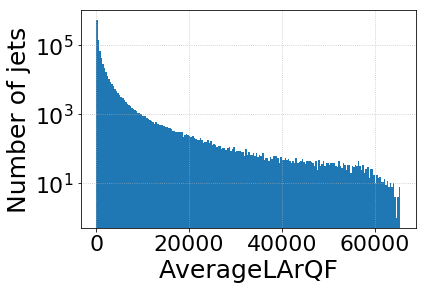

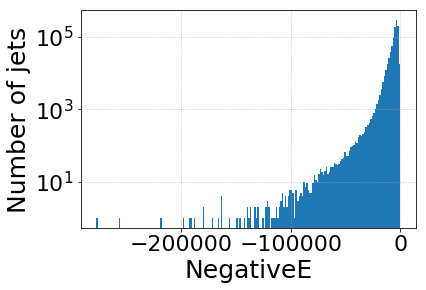

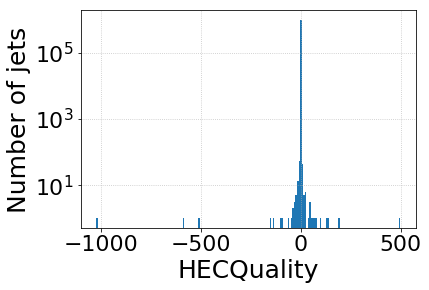

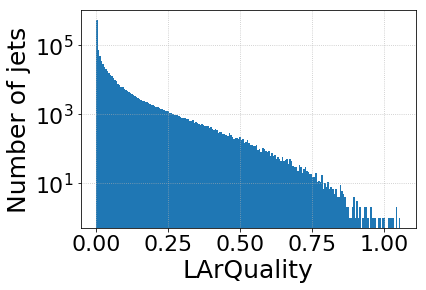

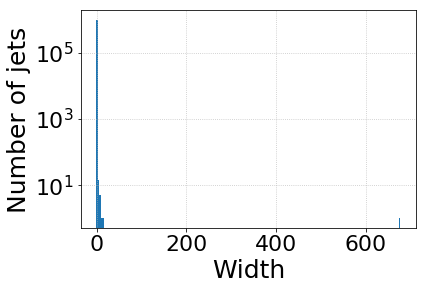

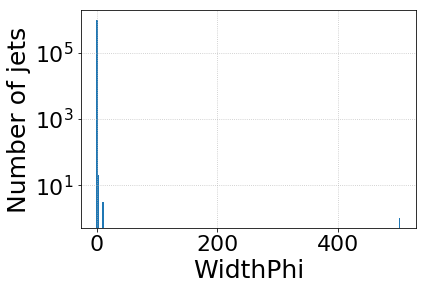

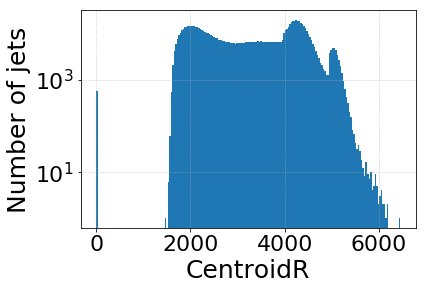

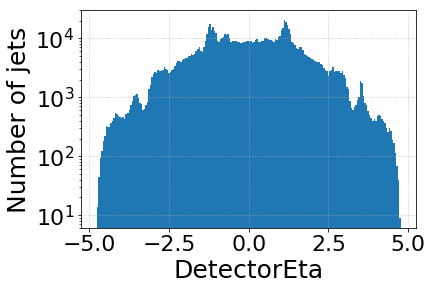

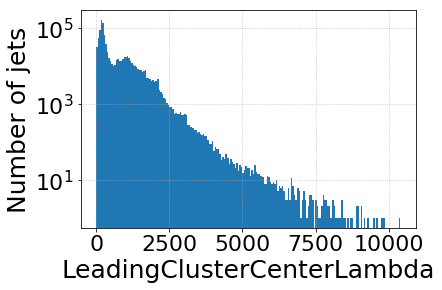

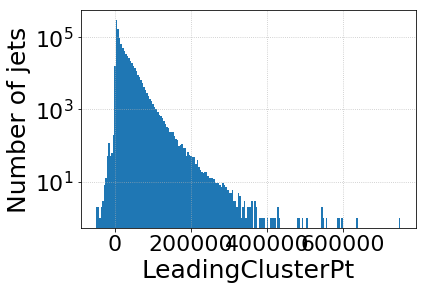

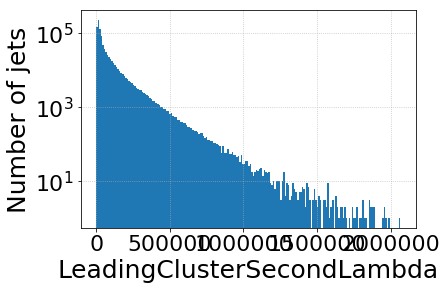

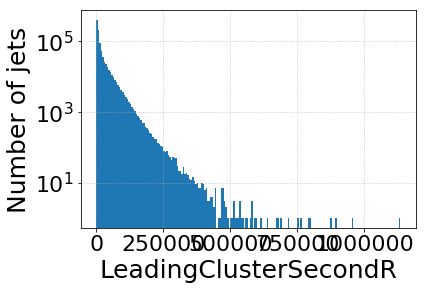

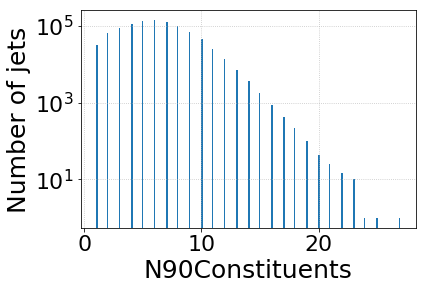

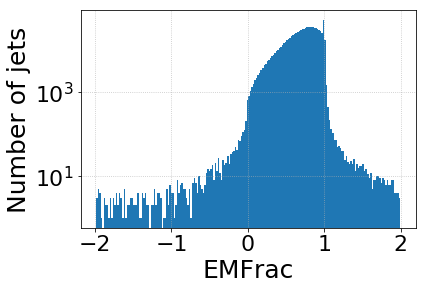

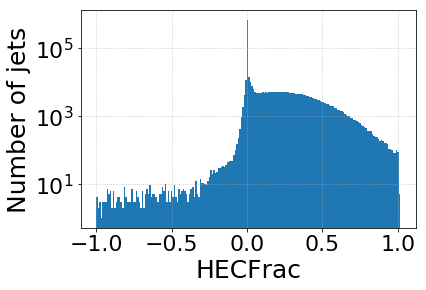

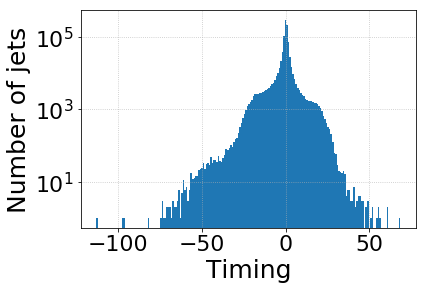

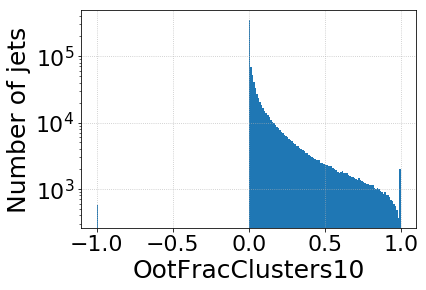

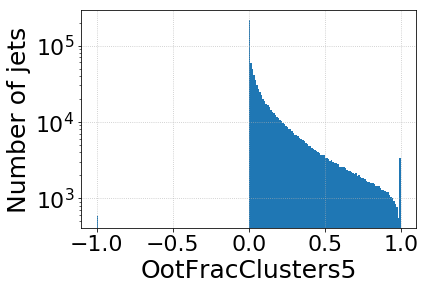

In [12]:
logy = True
plot_all(train, logy)

In [13]:
# Normalize
train_mean = train.mean()
train_std = train.std()

normed_train = (train - train_mean) / train_std
normed_test = (test - train_mean) / train_std

In [14]:
train_std

pt                             39924.871581
eta                                1.570283
phi                                1.810944
m                               4484.006130
ActiveArea                         0.045757
ActiveArea4vec_eta                 1.581545
ActiveArea4vec_m                   0.018330
ActiveArea4vec_phi                 1.810968
ActiveArea4vec_pt                  0.044101
AverageLArQF                    3936.944953
NegativeE                       4169.871158
HECQuality                         1.478825
LArQuality                         0.076939
Width                              0.697708
WidthPhi                           0.519908
CentroidR                       1011.165648
DetectorEta                        1.559710
LeadingClusterCenterLambda       615.609492
LeadingClusterPt               21735.602281
LeadingClusterSecondLambda    105995.441573
LeadingClusterSecondR          28517.641720
N90Constituents                    2.723011
EMFrac                          

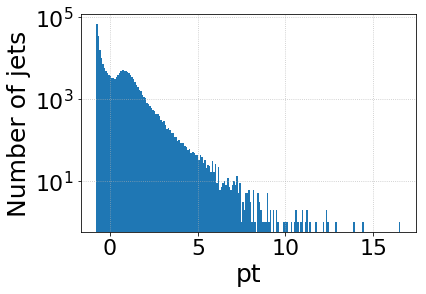

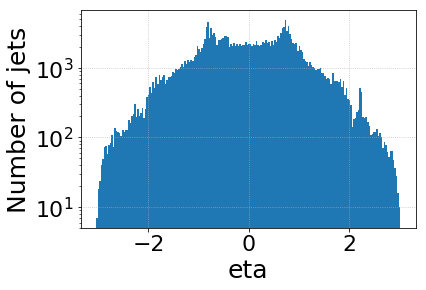

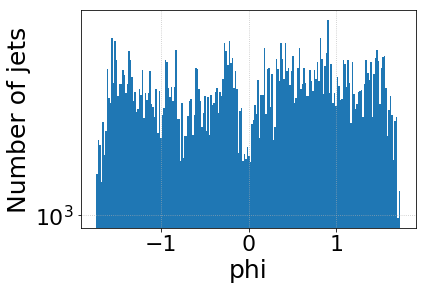

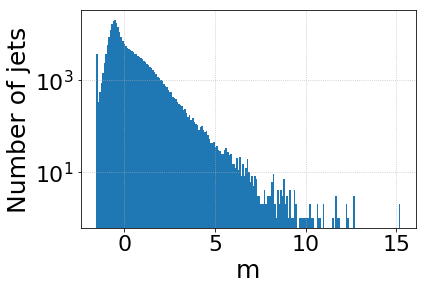

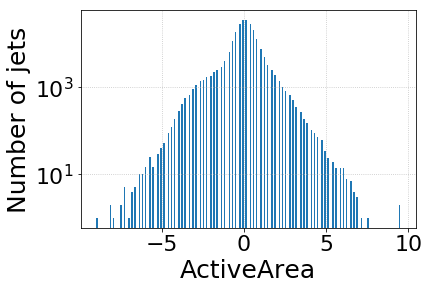

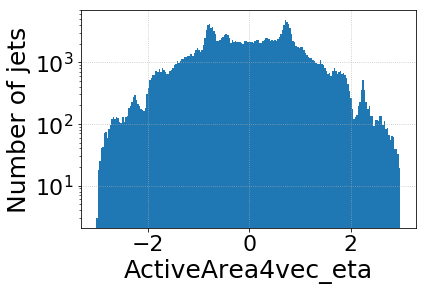

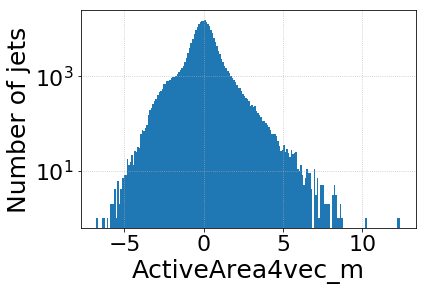

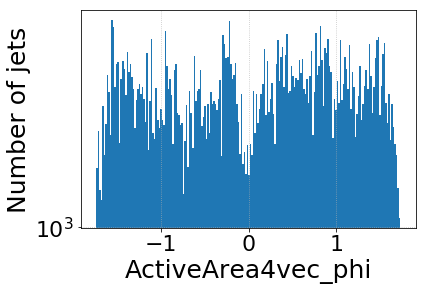

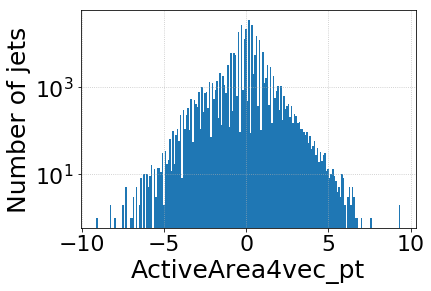

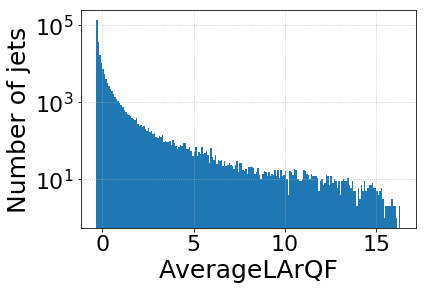

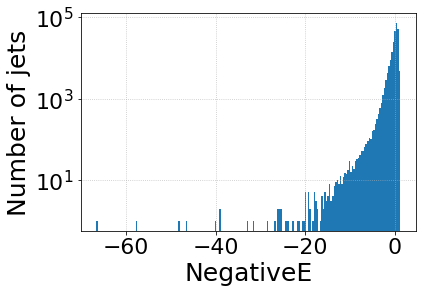

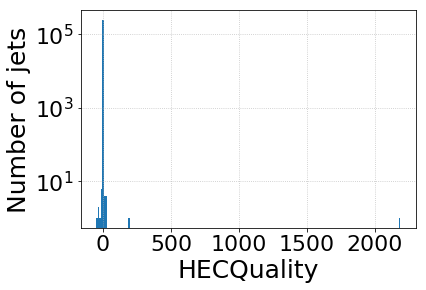

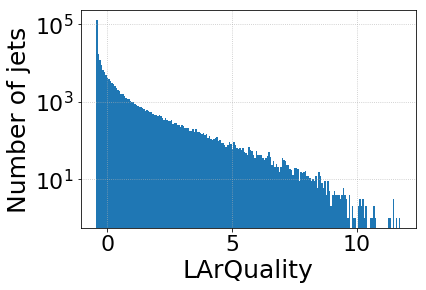

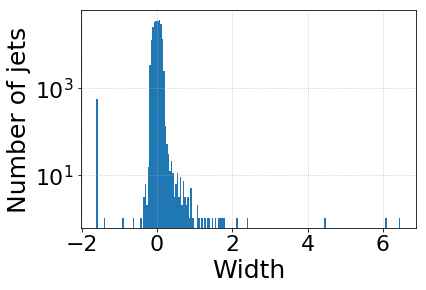

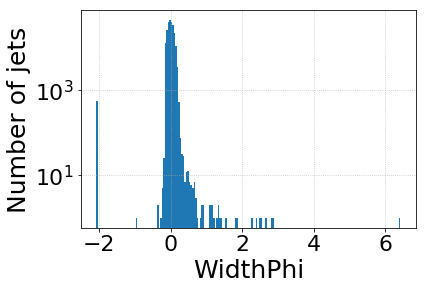

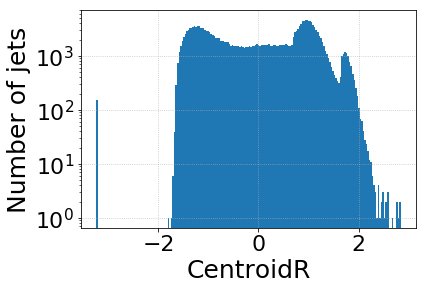

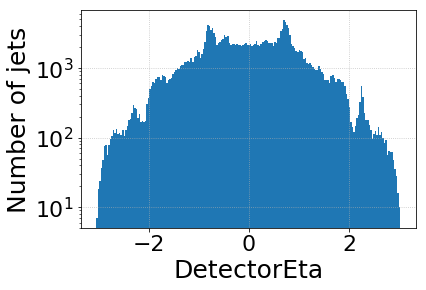

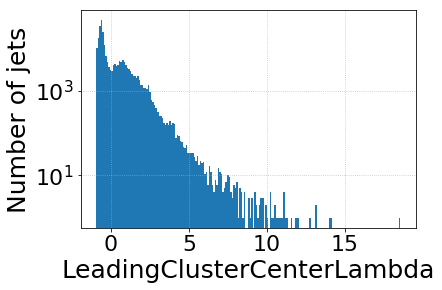

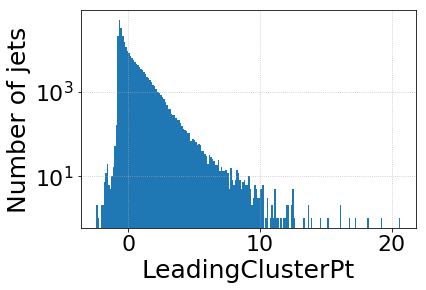

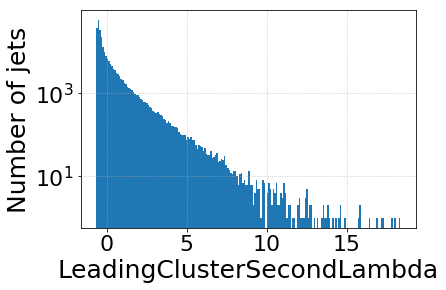

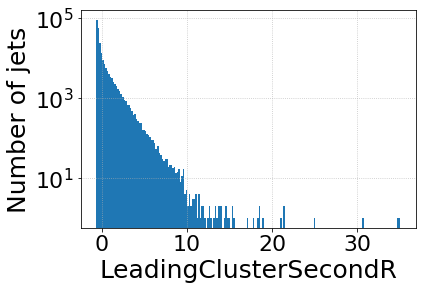

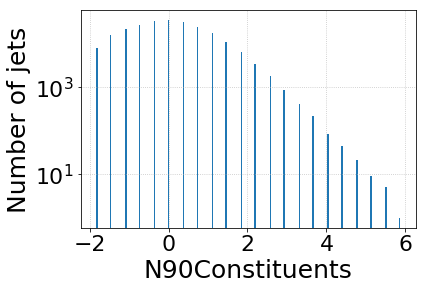

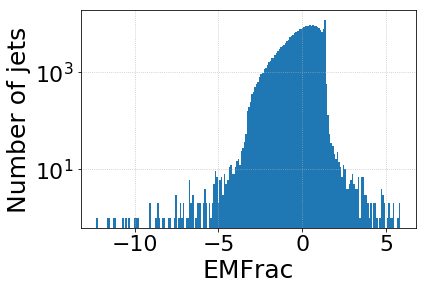

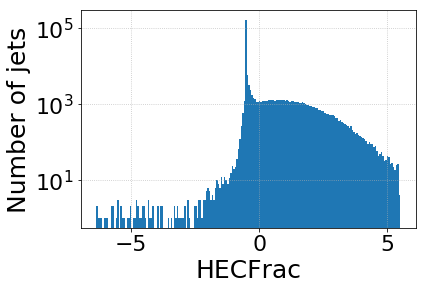

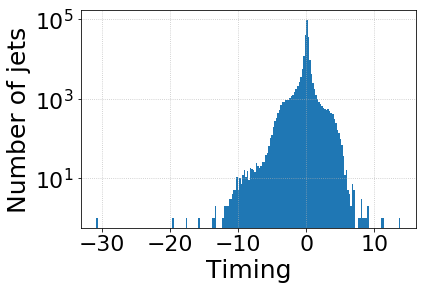

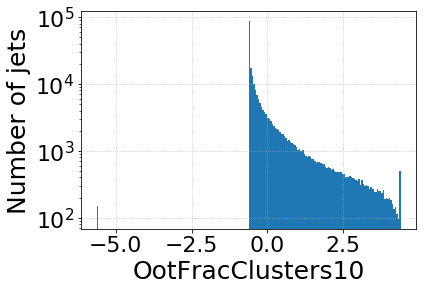

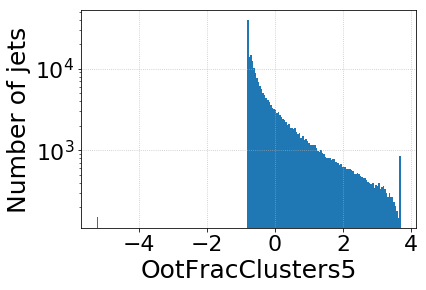

In [15]:
plot_all(data=normed_test, logy=True)

In [16]:
keys = ['pt',
        'eta',
        'phi',
        'm',
        'ActiveArea',
        'ActiveArea4vec_eta',
        'ActiveArea4vec_m',
        'ActiveArea4vec_phi',
        'ActiveArea4vec_pt',
        'AverageLArQF',
        'HECQuality',
        'LArQuality',
        'Width',
        'WidthPhi',
        'CentroidR',
        'DetectorEta',
        'LeadingClusterCenterLambda',
        'LeadingClusterPt',
        'LeadingClusterSecondLambda',
        'LeadingClusterSecondR',
        'N90Constituents',
        'EMFrac',
        'Timing',
        'OotFracClusters10',
        'HECQuality',
        'OotFracClusters5']
lognormed_variables = ['pt',
                       'LeadingClusterPt',
                       'LeadingClusterCenterLambda',
                       'LeadingClusterSecondLambda',
                       'LeadingClusterSecondR',
                       'CentroidR',
                       'LArQuality',                      
                      ]
custom_variables = [
                    'DetectorEta',
                    'ActiveArea4vec_eta',
                    'EMFrac',
                    'NegativeE',
                    ]
notnormed_variables = ['ActiveArea',
                       'ActiveArea4vec_m',
                       'ActiveArea4vec_pt',
                       'HECFrac',
                       'OotFracClusters10',
                       'OotFracClusters5',
                      ]

In [17]:
custom_normalized_test = test.copy()
for var in lognormed_variables:
    custom_normalized_test[var] = np.log10(test[var] + 100) - 2
custom_normalized_test['DetectorEta'] = test['DetectorEta'] / 5
custom_normalized_test['ActiveArea4vec_eta'] = test['ActiveArea4vec_eta'] / 5
custom_normalized_test['EMFrac'] = test['EMFrac'] / 5
custom_normalized_test['NegativeE'] = np.log10(-test['NegativeE'] + 1) / 4

/home/skelpdar/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/skelpdar/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/skelpdar/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


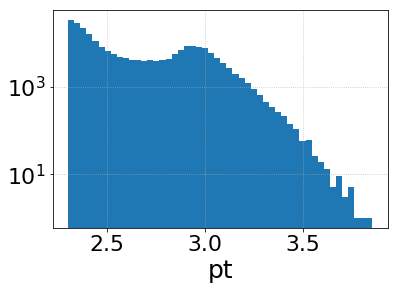

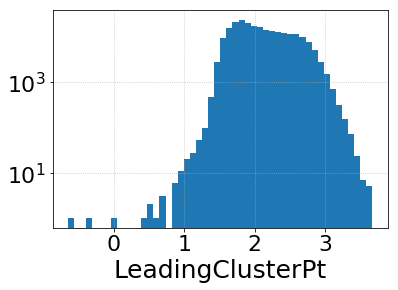

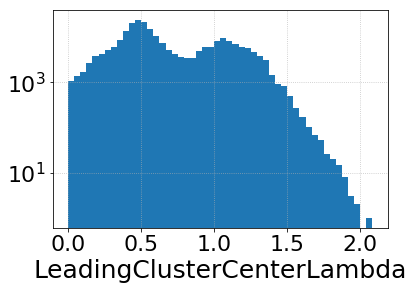

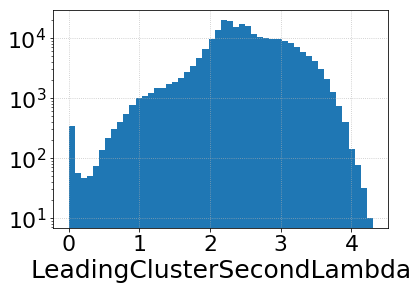

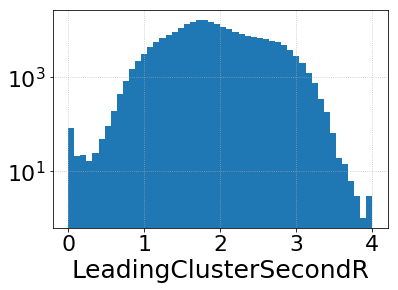

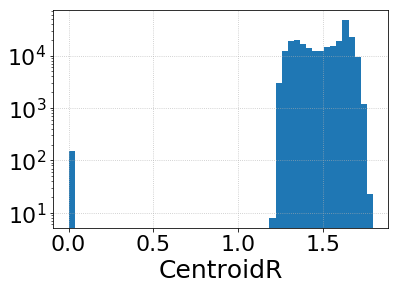

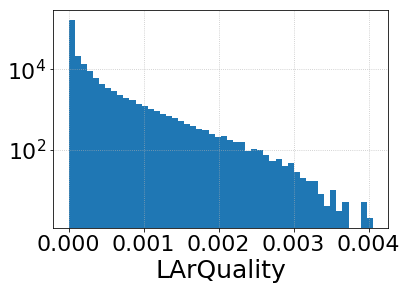

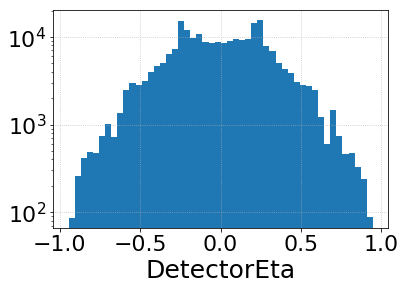

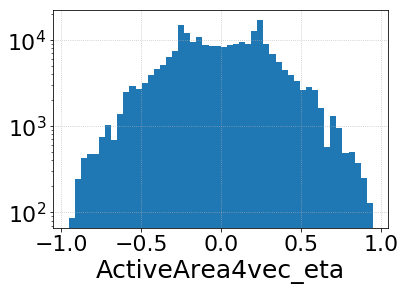

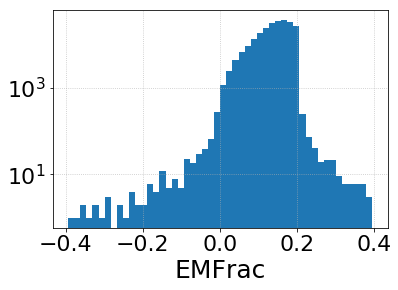

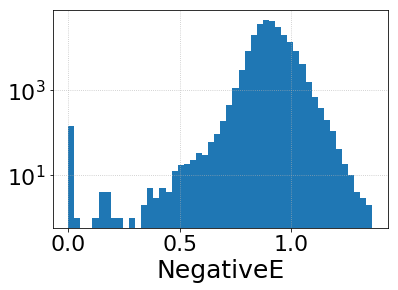

In [18]:
for var in lognormed_variables + custom_variables:
    plt.figure()
    plt.hist(custom_normalized_test[var], bins=50)
    plt.xlabel(var)
    plt.yscale('log')

In [19]:
from FunctionScaler import FunctionScaler
fs = FunctionScaler.FunctionScaler(FunctionScaler.TransformedFunction_Uniform(-1,1), downplay_outofbounds_lower_n_range=None, downplay_outofbounds_upper_n_range=None, downplay_outofbounds_lower_set_point=None, downplay_outofbounds_upper_set_point= None) # calling the normal function by name
#fs = FunctionScaler.FunctionScaler("gauss-11")
#fs = FunctionScaler.FunctionScaler("gauss")

ModuleNotFoundError: No module named 'FunctionScaler'

In [ ]:
scaling_data = test.values
fs.fit(scaling_data[:len(scaling_data)//5])

In [ ]:
scaled_data = fs.transform(scaling_data)

In [ ]:
scaled_df = pd.DataFrame(scaled_data, columns=test.columns)
scaled_df

In [ ]:
plot_all(scaled_df)

In [ ]:
unscaled_data = fs.invtransform(scaled_data)
unscaled_df = pd.DataFrame(unscaled_data, columns=test.columns)
unscaled_df

In [ ]:
plt.figure()
plt.hist(unscaled_df['pt'], bins=100, color='b')
plt.hist(train['pt'], bins=100, color='r', alpha=0.5)

In [ ]:
plot_all(unscaled_df)